# Demo - Probabilistic Fourier with AR model on coefficients

This file provides an demo of the probabilistic Fourier framework as outline in "Bayesian spectrum estimation of unevenly sampled data" - Qi et al.

$$ {\bf{s}}_t = {\bf{s}}_{t-1} + {\bf{w}}_t $$
$$ {\bf{y}}_t = C^\top {\bf{s}}_t + {\bf{v}}_t $$

## Load packages and functions

In [14]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using FFTW
using LAR
using LAR.Node
using Distributions

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
;

## Settings

In [15]:
# data loading
sound_file = "../data/woman.wav"   # specify sound location
fs_desired = 8000                  # specify desired sampling frequency

# input buffer parameters
step_size = 30                      # specify step size of buffer
buffer_size = 30                    # specify size of buffer

# probabilistic fourier parameters 
var_observation = 1e-3               # specify observation noise var
freq_bins = 15
freq = collect(fs_desired/(2*(freq_bins+1)):fs_desired/(2*(freq_bins+1)):(fs_desired/2-fs_desired/(2*(freq_bins+1))))

# AR modelling
AR_order = 1
iterations = 5
;

## Load data

In [16]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[1*fs_time+1:4*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 100*x_time/var(x_time)
x_time_clean = x_time
x_time = x_time_clean + rand(Distributions.Normal(0, sqrt(var_observation)), length(x_time_clean))

# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBgeOS97PAavk1rpr2ysLm9snSJOZkxQ7wc/DY98PsTPslKRz70A20+eUhjPrOMbj6wS1c+lercPRBvnjs2+qq87ikTvSWwtr0r5Eu+PKshvhctZb1PCmu9CvaBvb/1Cbx8hii7l4+ZPcCSKzy+Qje9B/XUvDWVjL2URgS+Up7SvaUPIb6ctsm9pcykvUS2n73OG4W9/fR+PW+f2j3jARc+V0dePnVUfT5ssW8+V2tsPu5CLT7xiZA9CJa7vMfbX7xsZha+VwBPvq+0Vr5meMm8sPhxvb5nAr0n8WG8WgYkPZmvFT0sXuQ9r7sjPQURTb1OCYG9ZlpcvaXg5L0AAry9m/QDvq6Lub1Y8My9qaRjvUE8rrvni1E+w/hOPhj8az6uRms+RHehPjZSXT7DeJc9MpOZvCym1jzJG969oQxovjBhc77Sz+29kv4VvhZW972z0r29wCbuPJRazT1V9vI9Pn7bvJCywjwL54U7m38+O/v6lr0LVRW+co0Gvlu+tb2m6Oi9/+SVvaxM7bxyNfI93JMAPif3Pz6qol8+hP6aPuhBgD731KM9RrmdPKROJjzGcqi61nkHvsuDeb5DiVK+0MUWviU3uL0+oOe9czj6PBi/ET0Lc1A8HsaPuwse0rxrVAa9trW6O8ezgbzWzQC+dky0vSi0pL3AAtQ8ZXFBvERGjj2LckI+6OBbPt9edj49HHw+Ej9bPvfEJj7LJAs9zh0IPGvVCb6N2IK+qPcJvvEG073Nci++LZ7FvVtYY70lCYE9UG7gPJ5UQT19R/48P5vnPNXLgT1hYr497qr4vESeI760twG+BCUnvjc9ZL66/uG9e6LSu9X8bz1nORk7FzjKPb3yKT7e7i4+sRsgPn7a6T0w1Ts9qgjePVhYFj0WJtm8bsCbvK/SFL2oKPi9DGHOvQUY3L3YV7S9gJtoveg/YL09bHo9OjVePV6DRr3qbKC9t7PzvDWIzrw2VIS9Df8TPa/5gjwJhO08wAoXPpFuWD4rORo+h+Z0Pk0OgT5yp0M9+OTxPImkNT0PEMK9wGGFvmFKgb5WzcK9xyrFvY9dIb4AIOK8tU0VPJlUGT6bI6491K6xPS9C4T0Oshg+uFuzPc0lv7t3exG9LqD4vSICg71cgPm9sH/0vS6IAL5gT0q8k0hovWP1N72u29G8VqGJPZffuj2HBS09YnuuPZ4qHj3rsn88Vv5evMEc87ytz5o8TGEJPEDtw7xU4lG9Vtg6vAii3LxaiDS6IzePPVWFhLzrpJ08IjA9OyD5Mzvg75q7YS4qvTB5ezu3ilO7h36WPeJ1Gz2cwJc9QTrnu9RZQDy6QDQ9naONPQLGIjxlIsE9W0/lPGDF6jxvtzE8iC0pvRvaDr0oWRC9jZJfO3a0izzjsre872JWvEY/jbpLIAC91QRTvIa1UbzDB4m97L0/vfC8WDw+xlk7g1QNPKLWlj3VZbo8Kjc6PVFU+zydW4o9bZ65PW6u8TyXIm09Tr8QPFEQtDvsmIi9hdhXvXIC5r2pNKi9mg6tvUlczb205w6+Vt4jvbh0Ur3AHTG9k7k1vW3bBj3FQiQ50/J3PRp9KT3xaHI9q5OBPdxs5z08x6w9hWUPPs4U0j0joqs9C14zPVN7UD2n2Yy8fdHKvZojwr2sFxi+oFDBvdBFFb6vheG9XrjyvS+4MLwu3Za9prVivT6nWbzrV8Y99MIVvPgdNj3aZrk9F5nxPZ6kZz2MXcw94/MaPoknLz7Tsek9vSMcPXkTZDyxXRU9v1txvWWgI75nvgi+XMKJvUFnkr1nQwG+flWivWQFQzyyyyO9ObdrvCvzWj3fpgg8Jr4kvAssUj0F3YQ9ohjdvHeC6rycFBO9BzwSvfG1xL0udci7uY3EvUzCwL0PlB29xu86vTd/qzyhdqE7PqROvaTb1DuOjby8YLsfvDasPj3TqqW9S6k8PW7QQjypxky9RxxHvGmJqzwZNUe8kpanPXfsSD1hEYy8muCDPUlqyTvmiKO845wPvZyRGj3MX7A7yqfyPE37hz35fg49kN2mvEYXSL0r/vg8k1BjPTL8db0/Qh08/uPgux+AxzxMFqA8bBPnO0VDjTzQTPO8UX3OO34ntbz9cF29sXyfPHX/bj30Oqc7aJhkuwwWNbxdmAu9mw6xuo+yMT3s90S7iXGHPU4DDTyEowE9WfhUu+I0D7sj5Tc9wpUAPdusCT3mXV48E5jNuxmZQz0Jp728C5N1vUcvq71HxXw82QR/PC1Zx7trMWw9hoq+PMzn6LtL90I9V4oWurXRZb32fQO939ToPOsW9jx4bhy97Oz9us14c7m3Ng48m8vvu3rAz7srnPY8uRUGPTRifTsRHhE9q3n2PBG6aTyObTC8GLz7PCRiv7yGDaK8gWwfPWRuBT3cjyW7ynTlvL9LOrxSSy28f+awPNAagL0t4yo8W1BdPFMq4ryQSc29erWKPRH8lj0IOy294iZePOmgiD3ivpY8VgpOvemeTzw96nc8hMeoPIVOar1SnjI9E+WdvDw0F706PAw9ibFCvWK22bvW4wa9hwKnPI1x7TxPlaY8WnhnvVpVmr3FTjY8T1Lfu3nW8rsb9pE8sdkTvRQJvLzm2nm9LRWTPP5BIj06Iry9F3SNvMfS0bxTlIi86KeRPGikK71XU428rOqQvEYZ4DsS4om8iowmveAzADy59AS8vQntPEa98bodw8g8E255vNnvSz1s90G9XfElPAI3NLx+sDO8KWQwu1pCzrzqL9g8AHq8PCoVN7zUpwY9vkgZva5jiz1DWCM9Fw8uvPMV8bxYWFA9gAAZPW85H72iE9K8XYcsvXodQbvT9Ns8F549PUrQJD1jY/M86Aw3vRXS3Lz11ia8C7NcvBjUXz10H7Y7zCC5O0bwhD0x/3y9nsLBPCFeqDuHF2E9QtmiO+ZZnTyS64O85g7bvObXcrw+L8C85xliu1N8yryPZDS9n8lnPNam5zyisJC9XoFwPEBI87vpHSe81+2ZvFL4QbwuCXk8LQ8nPRwzkzxgtzS891QxPKyPFLs7iIg975ZZvc3dojt2Uj68dRZMPcDzPzpxAis9nRSQPNKzN7wiVLG8rZpuu+Md+7yJDRe8vYohvCLrKj0wpTm8+U8eueshVD0qXBM9x16ePAnZGz1ETNw6Ths0vDpjlb0NhpI8m+3vOx/EJL1cF4M8ycYpPdyx+bwfuzY9WlpLPVhivjyWQai6MNtCu36EGDxfPUg8p82VOoxSfzx4OEY9J3BYvUFK3DvJ7Lk89mzLvFxbbzyyihO9eH0EvbYRMD3VZKc7YfrJPOJBvLsVVoq7sBbAu0PEaTyBWoq9QCyVPIlHZj0AnJA8wxCCPEveFD0rXKm8Rh20vIU7Fzq68Du8s1kGvEWXHb1m0wS7jDPAvIRVaj0XKn27ijtMvVTeL7zTknA90PYPPdNUszvtLkO8nHnZvEaUZ73RUSW9t79rPbhWJz1beDq9U99kPOCsq7zwX+S8iG2ZvK2l6bypYTK9CsaEPRP+Er2Qrxg9GaiIO4MoxjwQFhO9oVtJvGZ/d72T9ia9mzYfPJggDzy94Bq8TqmmOnRiIz1nbbE9S6iGPaudSTyX9II8d1CSPJUVmLr4ZC893JiTO+5lt71Iy2u9qZmVval8Pr2wn6I8GGcsvExDCz3maRc6nf08PGetkD1r/LQ8eUFmvR1KZLt0/q+7JNZDvMEI6bsZ7Yc8IQ6BPLaEgz35E7S8SOjYPN4ptDzniTS9HKvmPBNYa72NLHc7+TeRPFi/zTzla7Y8WQPgPETAHDxmrTA9/zxiPcS8SD09LMK7z+LMvE/9mTw05OI8J+zZPCf1pLyIZMo7YMQEuymxGLqCy8c8PZ6TPBOoyTtHH

## Visualize data

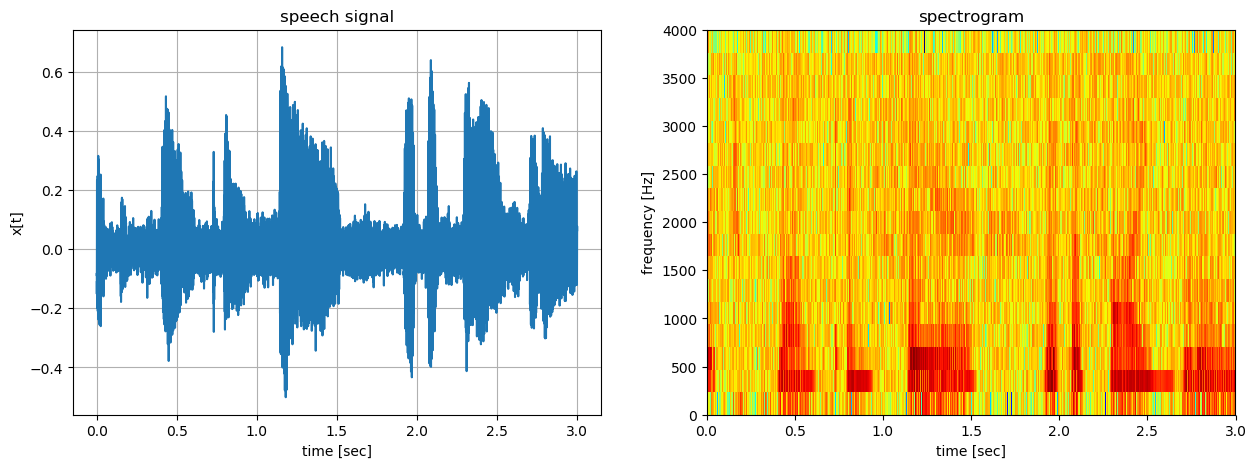

In [17]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, 32, 0, fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Specify generative model

In [18]:
# create factor graph
fg = FactorGraph()

# placeholders
z_min = Array{Variable,1}(undef, 2*length(freq))
Œ≥ = Array{Variable,1}(undef, 2*length(freq))
Œ∏ = Array{Variable,1}(undef, 2*length(freq))
z = Array{Variable,1}(undef, 2*length(freq))

# specify observation noise
@RV v ~ GaussianMeanVariance(zeros(buffer_size), var_observation*Ic(buffer_size))

# specify previous hidden state (spectral component buffer)
for k = 1:2*length(freq)
    @RV [id=pad(:z_min,k)] z_min[k] ~ GaussianMeanVariance(placeholder(pad(:Œº_z_min, k), dims = (AR_order,)),
                                        placeholder(pad(:Œ£_z_min, k), dims = (AR_order, AR_order)))
    @RV [id=pad(:Œ≥,k)] Œ≥[k] ~ ForneyLab.Gamma(placeholder(pad(:a_Œ≥,k)), placeholder(pad(:b_Œ≥,k)))
    @RV [id=pad(:Œ∏,k)] Œ∏[k] ~ GaussianMeanVariance(placeholder(pad(:Œº_Œ∏,k), dims=(AR_order,)), placeholder(pad(:Œ£_Œ∏,k), dims=(AR_order, AR_order)))
    @RV [id=pad(:z,k)] z[k] ~ LAR.Autoregressive(Œ∏[k], z_min[k], Œ≥[k])
end

# specify Fourier matrix
Ceme1 = Array{Variable,1}(undef, 2*length(freq))
for k=1:2*length(freq)
    @RV Ceme1[k] 
    placeholder(Ceme1[k], pad(:Ceme1,k), dims = (buffer_size, AR_order))
end

# specify observations
@RV x = sum(Ceme1.*z)
@RV y = x + v

# create placeholder for observations
placeholder(y, :y, dims = (buffer_size,))

# draw factor graph
ForneyLab.draw(fg)
ForneyLab.draw(fg, external_viewer=:default)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 13172466539946539040 -->
 13172466539946539040 
 
 AR 
 autoregressive_23 
 
<!-- 1427257692614790131 -->
 1427257692614790131 
 
 Gam 
 gamma_23 
 
<!-- 13172466539946539040--1427257692614790131 -->
 13172466539946539040--1427257692614790131 
 
 Œ≥_23 
 1 out 
 4 Œ≥ 
 
<!-- 17852885950836155579 -->
 17852885950836155579 
 
 ùí© 
 gaussianmeanvariance_47 
 
<!-- 13172466539946539040--17852885950836155579 -->
 13172466539946539040--17852885950836155579 
 
 Œ∏_23 
 1 out 
 3 Œ∏ 
 
<!-- 12938958232482915997 -->
 12938958232482915997 
 
 ùí© 
 gaussianmeanvariance_46 
 
<!-- 13172466539946539040--12938958232482915997 -->
 13172466539946539040--12938958232482915997 
 
 z_min_23 
 1 out 
 2 x 
 
<!-- 17977570378354669639 -->
 17977570378354669639 
 
 placeholder_Œº_Œ∏_10 
 
<!-- 6886416326736342088 -->
 6886416326736342088 
 
 placeholder_Œº_Œ∏_09 
 
<!-- 2785177909582584907 -->
 2785177909582584907 
 
 ùí© 
 gaussianmeanvariance_37 
 
<!-- 13936988313318438190 -->
 13936988313318438190 
 
 placeholder_Œº_Œ∏_18 
 
<!-- 2785177909582584907--13936988313318438190 -->
 2785177909582584907--13936988313318438190 
 
 Œº_Œ∏_18 
 1 out 
 2 m 
 
<!-- 16633372014965728871 -->
 16633372014965728871 
 
 placeholder_Œ£_Œ∏_18 
 
<!-- 2785177909582584907--16633372014965728871 -->
 2785177909582584907--16633372014965728871 
 
 Œ£_Œ∏_18 
 1 out 
 3 v 
 
<!-- 6190213696228946862 -->
 6190213696228946862 
 
 AR 
 autoregressive_2 
 
<!-- 10932349598905026482 -->
 10932349598905026482 
 
 Gam 
 gamma_2 
 
<!-- 6190213696228946862--10932349598905026482 -->
 6190213696228946862--10932349598905026482 
 
 Œ≥_02 
 1 out 
 4 Œ≥ 
 
<!-- 5354503958726040094 -->
 5354503958726040094 
 
 ùí© 
 gaussianmeanvariance_5 
 
<!-- 6190213696228946862--5354503958726040094 -->
 6190213696228946862--5354503958726040094 
 
 Œ∏_02 
 1 out 
 3 Œ∏ 
 
<!-- 2115024446860526839 -->
 2115024446860526839 
 
 ùí© 
 gaussianmeanvariance_4 
 
<!-- 6190213696228946862--2115024446860526839 -->
 6190213696228946862--2115024446860526839 
 
 z_min_02 
 1 out 
 2 x 
 
<!-- 13774989609339466893 -->
 13774989609339466893 
 
 placeholder_Œº_z_min_24 
 
<!-- 8900457592343197592 -->
 8900457592343197592 
 
 placeholder_b_Œ≥_24 
 
<!-- 8212015660652946723 -->
 8212015660652946723 
 
 √ó 
 multiplication_19 
 
<!-- 12014880172036309722 -->
 12014880172036309722 
 
 AR 
 autoregressive_19 
 
<!-- 8212015660652946723--12014880172036309722 -->
 8212015660652946723--12014880172036309722 
 
 z_19 
 1 y 
 2 in1 
 
<!-- 6474785642967624990 -->
 6474785642967624990 
 
 placeholder_Ceme1_19 
 
<!-- 8212015660652946723--6474785642967624990 -->
 8212015660652946723--6474785642967624990 
 
 Ceme1_19 
 1 out 
 3 a 
 
<!-- 9444369358312592328 -->
 9444369358312592328 
 
 ùí© 
 gaussianmeanvariance_7 
 
<!-- 4222880689606386471 -->
 4222880689606386471 
 
 placeholder_Œ£_Œ∏_03 
 
<!-- 9444369358312592328--4222880689606386471 -->
 9444369358312592328--4222880689606386471 
 
 Œ£_Œ∏_03 
 1 out 
 3 v 
 
<!-- 636678517996578856 -->
 636678517996578856 
 
 placeholder_Œº_Œ∏_03 
 
<!-- 9444369358312592328--636678517996578856 -->
 9444369358312592328--636678517996578856 
 
 Œº_Œ∏_03 
 1 out 
 2 m 
 
<!-- 15098154978853241250 -->
 15098154978853241250 
 
 placeholder_Œ£_z_min_18 
 
<!-- 3043375385587944737 -->
 3043375385587944737 
 
 placeholder_Œº_z_min_03 
 
<!-- 10416852402433140311 -->
 10416852402433140311 
 
 placeholder_Œ£_Œ∏_05 
 
<!-- 11514793582371636117 -->
 11514793582371636117 
 
 ùí© 
 gaussianmeanvariance_48 
 
<!--

In [19]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(Œ∏, z, z_min, Œ≥, ids=[:Œ∏ :z :z_min :Œ≥])
algo = compatibility_fix(variationalAlgorithm(q))
# algo_F = freeEnergyAlgorithm(q) # throws error because the variables z are all connected

# evaluate algorithm
eval(Meta.parse(algo))
;

In [20]:
println(algo)

begin

function stepŒ≥!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 60))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_Œ≥_30]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_Œ≥_30]))
messages[2] = ruleVariationalARIn3PPPN(marginals[:z_30], marginals[:z_min_30], marginals[:Œ∏_30], nothing)
messages[3] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_Œ≥_29]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_Œ≥_29]))
messages[4] = ruleVariationalARIn3PPPN(marginals[:z_29], marginals[:z_min_29], marginals[:Œ∏_29], nothing)
messages[5] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_Œ≥_28]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_Œ≥_28]))
messages[6] = ruleVariationalARIn3PPPN(marginals[:z_28], marginals[:z_min_28], marginals[:Œ∏_28], noth

## Perform inference

In [21]:
messages=Array{Message}(undef, 180)
data = Dict()
marginals = Dict()

# create placeholders for priors
Œº_z_min = Array{Array{Float64,1},1}(undef, 2*length(freq))
Œ£_z_min = Array{Array{Float64,2},1}(undef, 2*length(freq))
a_Œ≥_min = Array{Float64,1}(undef, 2*length(freq))
b_Œ≥_min = Array{Float64,1}(undef, 2*length(freq))
Œº_Œ∏_min = Array{Array{Float64,1},1}(undef, 2*length(freq))
Œ£_Œ∏_min = Array{Array{Float64,2},1}(undef, 2*length(freq))

# set priors 
for k = 1:2*length(freq)
    Œº_z_min[k] = randn(AR_order)
    Œ£_z_min[k] = 1e10*Ic(AR_order)
    a_Œ≥_min[k] = 0.001
    b_Œ≥_min[k] = 0.001
    Œº_Œ∏_min[k] = randn(AR_order)
    Œ£_Œ∏_min[k] = 1e0*Ic(AR_order)
end

# create marginals
for k = 1:2*length(freq)
    marginals[pad(:Œ≥, k)] = ProbabilityDistribution(ForneyLab.Univariate, ForneyLab.Gamma, a=a_Œ≥_min[k], b=b_Œ≥_min[k])
    marginals[pad(:Œ∏, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=Œº_Œ∏_min[k], v=Œ£_Œ∏_min[k])
    marginals[pad(:z_min, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=Œº_z_min[k], v=Œ£_z_min[k])
end

# initialize buffer
buf = BufferData(x_time, t, buffer_size)

# initialize placeholder for hidden states and observation
Œº_x = Array{Float64,1}[]
Œ£_x = Array{Float64,2}[]
Œº_s = Array{Float64,1}[]
Œ£_s = Array{Float64,2}[]

# create progress bar
p = Progress(len(buf, step_size), 1, "Observed ")

# loop through samples
for k = 1:len(buf, step_size)
        
    # update progress bar
    update!(p, k)
    
    # update data dictionary
    data[:y] = buf.buffer_s
    for f = 1:2*length(freq)
        data[pad(:Ceme1,f)] = calc_C(freq, buf.buffer_t)*em(2*length(freq), f)*(em(AR_order, 1)')
        data[pad(:a_Œ≥, f)] = a_Œ≥_min[f]
        data[pad(:b_Œ≥, f)] = b_Œ≥_min[f]
        data[pad(:Œº_Œ∏, f)] = Œº_Œ∏_min[f]
        data[pad(:Œ£_Œ∏, f)] = Œ£_Œ∏_min[f]
        data[pad(:Œº_z_min, f)] = Œº_z_min[f]
        data[pad(:Œ£_z_min, f)] = Œ£_z_min[f]
    end
    
    # run stepz! for prediction of x
    marginals = Base.invokelatest(stepz!, data, marginals, messages)  

    # get prediction of x
    push!(Œº_x, ForneyLab.unsafeMean(messages[179].dist))
    push!(Œ£_x, ForneyLab.unsafeCov(messages[179].dist))
    
    # infer parameters
    for it = 1:iterations
        
        # perform steps (z last to get prediction of x)
        marginals = Base.invokelatest(stepz!, data, marginals, messages)  
        marginals = Base.invokelatest(stepz_min!, data, marginals, messages)
        marginals = Base.invokelatest(stepŒ≥!, data, marginals, messages)
        marginals = Base.invokelatest(stepŒ∏!, data, marginals, messages)
        
    end
    
    # get spectral component values
    push!(Œº_s, [ForneyLab.unsafeMean(marginals[pad(:z, k)])[1] for k=1:2*length(freq)])
    push!(Œ£_s, diagm([ForneyLab.unsafeCov(marginals[pad(:z, k)])[1,1] for k=1:2*length(freq)]))
    
    # update hidden states
    for f = 1:2*length(freq)
        Œº_z_min[f] = ForneyLab.unsafeMean(marginals[pad(:z,f)])
        Œ£_z_min[f] = ForneyLab.unsafeCov(marginals[pad(:z,f)])
        a_Œ≥_min[f] = marginals[pad(:Œ≥,f)].params[:a]
        b_Œ≥_min[f] = marginals[pad(:Œ≥,f)].params[:b]
        Œº_Œ∏_min[f] = ForneyLab.unsafeMean(marginals[pad(:Œ∏,f)])
        Œ£_Œ∏_min[f] = ForneyLab.unsafeCov(marginals[pad(:Œ∏,f)])
    end
    
    # update buffer
    FLAG_data_remaining = step!(buf, step_size)
    
end

Observed 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:01:01


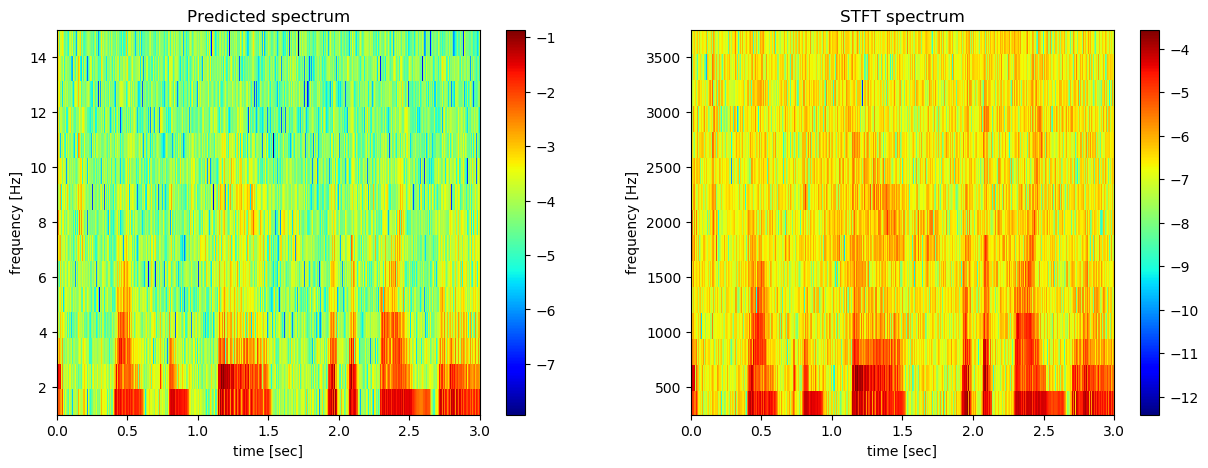

In [22]:
# convert Œº_x to a 1d array
#Œº_x_pred = expand((hcat(Œº_x...),dims=1))

# convert s_x to a 2d array
if length(size(Œº_s)) != 2
    Œº_s = hcat(Œº_s...)
end

# calculate magnitude spectrum
mag_Œº_s = log10.((Œº_s[1:length(freq),:].^2 + Œº_s[length(freq)+1:end,:].^2))


# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
cmp = ax[1].imshow(mag_Œº_s,
                   aspect="auto",
                   cmap="jet",
                   origin="lower",
                   extent=[minimum(t), maximum(t), 1, length(freq)])
fig.colorbar(cmp, ax=ax[1])

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, 2*length(freq)+1, 0, fs=fs_desired), fs_desired, ax=ax[2], colorbar=true)

# change visuals
ax[1].set_xlim(minimum(t), maximum(t)), ax[2].set_ylim(minimum(freq), maximum(freq)), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency [Hz]"), ax[1].set_title("Predicted spectrum"), ax[2].set_title("STFT spectrum")
#cmp.set_clim(-3, -16)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBgeOS97PAavk1rpr2ysLm9snSJOZkxQ7wc/DY98PsTPslKRz70A20+eUhjPrOMbj6wS1c+lercPRBvnjs2+qq87ikTvSWwtr0r5Eu+PKshvhctZb1PCmu9CvaBvb/1Cbx8hii7l4+ZPcCSKzy+Qje9B/XUvDWVjL2URgS+Up7SvaUPIb6ctsm9pcykvUS2n73OG4W9/fR+PW+f2j3jARc+V0dePnVUfT5ssW8+V2tsPu5CLT7xiZA9CJa7vMfbX7xsZha+VwBPvq+0Vr5meMm8sPhxvb5nAr0n8WG8WgYkPZmvFT0sXuQ9r7sjPQURTb1OCYG9ZlpcvaXg5L0AAry9m/QDvq6Lub1Y8My9qaRjvUE8rrvni1E+w/hOPhj8az6uRms+RHehPjZSXT7DeJc9MpOZvCym1jzJG969oQxovjBhc77Sz+29kv4VvhZW972z0r29wCbuPJRazT1V9vI9Pn7bvJCywjwL54U7m38+O/v6lr0LVRW+co0Gvlu+tb2m6Oi9/+SVvaxM7bxyNfI93JMAPif3Pz6qol8+hP6aPuhBgD731KM9RrmdPKROJjzGcqi61nkHvsuDeb5DiVK+0MUWviU3uL0+oOe9czj6PBi/ET0Lc1A8HsaPuwse0rxrVAa9trW6O8ezgbzWzQC+dky0vSi0pL3AAtQ8ZXFBvERGjj2LckI+6OBbPt9edj49HHw+Ej9bPvfEJj7LJAs9zh0IPGvVCb6N2IK+qPcJvvEG073Nci++LZ7FvVtYY70lCYE9UG7gPJ5UQT19R/48P5vnPNXLgT1hYr497qr4vESeI760twG+BCUnvjc9ZL66/uG9e6LSu9X8bz1nORk7FzjKPb3yKT7e7i4+sRsgPn7a6T0w1Ts9qgjePVhYFj0WJtm8bsCbvK/SFL2oKPi9DGHOvQUY3L3YV7S9gJtoveg/YL09bHo9OjVePV6DRr3qbKC9t7PzvDWIzrw2VIS9Df8TPa/5gjwJhO08wAoXPpFuWD4rORo+h+Z0Pk0OgT5yp0M9+OTxPImkNT0PEMK9wGGFvmFKgb5WzcK9xyrFvY9dIb4AIOK8tU0VPJlUGT6bI6491K6xPS9C4T0Oshg+uFuzPc0lv7t3exG9LqD4vSICg71cgPm9sH/0vS6IAL5gT0q8k0hovWP1N72u29G8VqGJPZffuj2HBS09YnuuPZ4qHj3rsn88Vv5evMEc87ytz5o8TGEJPEDtw7xU4lG9Vtg6vAii3LxaiDS6IzePPVWFhLzrpJ08IjA9OyD5Mzvg75q7YS4qvTB5ezu3ilO7h36WPeJ1Gz2cwJc9QTrnu9RZQDy6QDQ9naONPQLGIjxlIsE9W0/lPGDF6jxvtzE8iC0pvRvaDr0oWRC9jZJfO3a0izzjsre872JWvEY/jbpLIAC91QRTvIa1UbzDB4m97L0/vfC8WDw+xlk7g1QNPKLWlj3VZbo8Kjc6PVFU+zydW4o9bZ65PW6u8TyXIm09Tr8QPFEQtDvsmIi9hdhXvXIC5r2pNKi9mg6tvUlczb205w6+Vt4jvbh0Ur3AHTG9k7k1vW3bBj3FQiQ50/J3PRp9KT3xaHI9q5OBPdxs5z08x6w9hWUPPs4U0j0joqs9C14zPVN7UD2n2Yy8fdHKvZojwr2sFxi+oFDBvdBFFb6vheG9XrjyvS+4MLwu3Za9prVivT6nWbzrV8Y99MIVvPgdNj3aZrk9F5nxPZ6kZz2MXcw94/MaPoknLz7Tsek9vSMcPXkTZDyxXRU9v1txvWWgI75nvgi+XMKJvUFnkr1nQwG+flWivWQFQzyyyyO9ObdrvCvzWj3fpgg8Jr4kvAssUj0F3YQ9ohjdvHeC6rycFBO9BzwSvfG1xL0udci7uY3EvUzCwL0PlB29xu86vTd/qzyhdqE7PqROvaTb1DuOjby8YLsfvDasPj3TqqW9S6k8PW7QQjypxky9RxxHvGmJqzwZNUe8kpanPXfsSD1hEYy8muCDPUlqyTvmiKO845wPvZyRGj3MX7A7yqfyPE37hz35fg49kN2mvEYXSL0r/vg8k1BjPTL8db0/Qh08/uPgux+AxzxMFqA8bBPnO0VDjTzQTPO8UX3OO34ntbz9cF29sXyfPHX/bj30Oqc7aJhkuwwWNbxdmAu9mw6xuo+yMT3s90S7iXGHPU4DDTyEowE9WfhUu+I0D7sj5Tc9wpUAPdusCT3mXV48E5jNuxmZQz0Jp728C5N1vUcvq71HxXw82QR/PC1Zx7trMWw9hoq+PMzn6LtL90I9V4oWurXRZb32fQO939ToPOsW9jx4bhy97Oz9us14c7m3Ng48m8vvu3rAz7srnPY8uRUGPTRifTsRHhE9q3n2PBG6aTyObTC8GLz7PCRiv7yGDaK8gWwfPWRuBT3cjyW7ynTlvL9LOrxSSy28f+awPNAagL0t4yo8W1BdPFMq4ryQSc29erWKPRH8lj0IOy294iZePOmgiD3ivpY8VgpOvemeTzw96nc8hMeoPIVOar1SnjI9E+WdvDw0F706PAw9ibFCvWK22bvW4wa9hwKnPI1x7TxPlaY8WnhnvVpVmr3FTjY8T1Lfu3nW8rsb9pE8sdkTvRQJvLzm2nm9LRWTPP5BIj06Iry9F3SNvMfS0bxTlIi86KeRPGikK71XU428rOqQvEYZ4DsS4om8iowmveAzADy59AS8vQntPEa98bodw8g8E255vNnvSz1s90G9XfElPAI3NLx+sDO8KWQwu1pCzrzqL9g8AHq8PCoVN7zUpwY9vkgZva5jiz1DWCM9Fw8uvPMV8bxYWFA9gAAZPW85H72iE9K8XYcsvXodQbvT9Ns8F549PUrQJD1jY/M86Aw3vRXS3Lz11ia8C7NcvBjUXz10H7Y7zCC5O0bwhD0x/3y9nsLBPCFeqDuHF2E9QtmiO+ZZnTyS64O85g7bvObXcrw+L8C85xliu1N8yryPZDS9n8lnPNam5zyisJC9XoFwPEBI87vpHSe81+2ZvFL4QbwuCXk8LQ8nPRwzkzxgtzS891QxPKyPFLs7iIg975ZZvc3dojt2Uj68dRZMPcDzPzpxAis9nRSQPNKzN7wiVLG8rZpuu+Md+7yJDRe8vYohvCLrKj0wpTm8+U8eueshVD0qXBM9x16ePAnZGz1ETNw6Ths0vDpjlb0NhpI8m+3vOx/EJL1cF4M8ycYpPdyx+bwfuzY9WlpLPVhivjyWQai6MNtCu36EGDxfPUg8p82VOoxSfzx4OEY9J3BYvUFK3DvJ7Lk89mzLvFxbbzyyihO9eH0EvbYRMD3VZKc7YfrJPOJBvLsVVoq7sBbAu0PEaTyBWoq9QCyVPIlHZj0AnJA8wxCCPEveFD0rXKm8Rh20vIU7Fzq68Du8s1kGvEWXHb1m0wS7jDPAvIRVaj0XKn27ijtMvVTeL7zTknA90PYPPdNUszvtLkO8nHnZvEaUZ73RUSW9t79rPbhWJz1beDq9U99kPOCsq7zwX+S8iG2ZvK2l6bypYTK9CsaEPRP+Er2Qrxg9GaiIO4MoxjwQFhO9oVtJvGZ/d72T9ia9mzYfPJggDzy94Bq8TqmmOnRiIz1nbbE9S6iGPaudSTyX9II8d1CSPJUVmLr4ZC893JiTO+5lt71Iy2u9qZmVval8Pr2wn6I8GGcsvExDCz3maRc6nf08PGetkD1r/LQ8eUFmvR1KZLt0/q+7JNZDvMEI6bsZ7Yc8IQ6BPLaEgz35E7S8SOjYPN4ptDzniTS9HKvmPBNYa72NLHc7+TeRPFi/zTzla7Y8WQPgPETAHDxmrTA9/zxiPcS8SD09LMK7z+LMvE/9mTw05OI8J+zZPCf1pLyIZMo7YMQEuymxGLqCy8c8PZ6TPBOoyTtHH

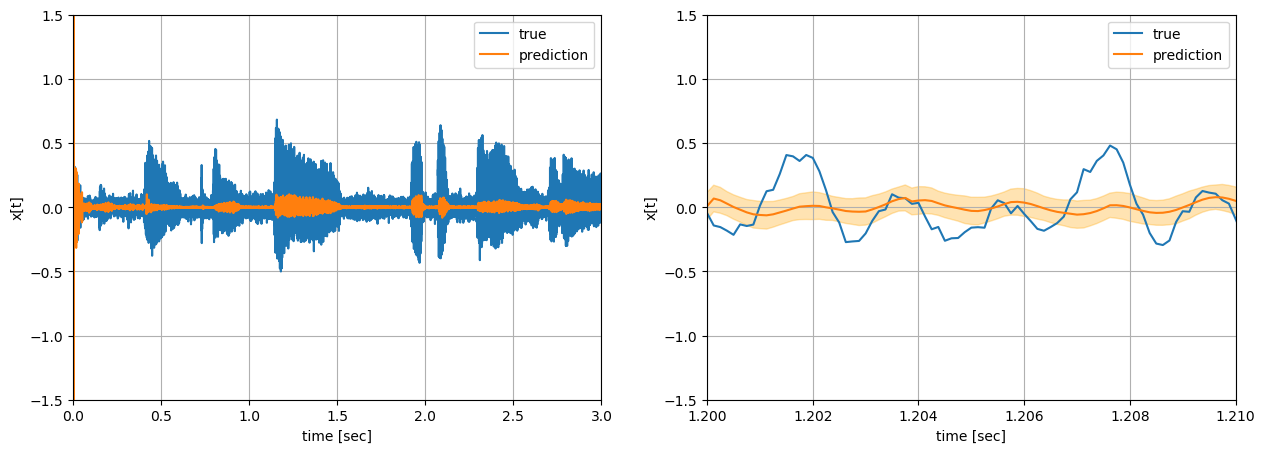

In [27]:
# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

Œº_x_pred_select = simplify(reverse(hcat(Œº_x...), dims=1))
var_x_pred_select = expand([reverse(diag(Œ£_x[k])) for k =1:length(Œ£_x)])

# plot actual, noisy and marginal of frequency component
ax[1].plot(t, x_time, label="true"), ax[1].plot(t[1:length(Œº_x_pred_select)], Œº_x_pred_select, label="prediction")#, ax[1].plot(t[1:length(Œº_x_pred_norm)], Œº_x_pred_norm, label="normalized prediction")
ax[2].plot(t, x_time, label="true"), ax[2].plot(t[1:length(Œº_x_pred_select)], Œº_x_pred_select, label="prediction")#, ax[2].plot(t[1:length(Œº_x_pred_norm)], Œº_x_pred_norm, label="normalized prediction")
ax[2].fill_between(t[1:length(Œº_x_pred_select)], Œº_x_pred_select .- sqrt.(var_x_pred_select), Œº_x_pred_select .+ sqrt.(var_x_pred_select), alpha=0.3, color="orange")

# change vizualization
ax[1].grid(), ax[1].set_xlim(0,3), ax[1].set_ylim(-1.5, 1.5), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("x[t]"), ax[1].legend()
ax[2].grid(), ax[2].set_xlim(1.2,1.21), ax[2].set_ylim(-1.5, 1.5), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("x[t]"), ax[2].legend()

# create audioplayers
audioplayers(x_time, x_time_clean, Œº_x_pred_select, fs=fs_desired)
;

## Performance metrics

In [28]:
MSE = 1/length(Œº_x_pred_select) * sum(abs.(Œº_x_pred_select - x_time[1:length(Œº_x_pred_select)]).^2)

0.0387445073121442

In [29]:
MAE = 1/length(Œº_x_pred_select) * sum(abs.(Œº_x_pred_select - x_time[1:length(Œº_x_pred_select)]))

0.07771514522810688

In [30]:
using Distributions;
logBME = Float64[]
# initialize buffer
buf = BufferData(x_time, t, buffer_size)
for k = 1:length(Œº_x)
    try 
        push!(logBME, sum([1/buffer_size*logpdf(Distributions.Normal(Œº_x[k][ki], sqrt(Œ£_x[k][ki,ki])), buf.buffer_s[ki]) for ki=1:buffer_size]))
    catch
    end
    step!(buf, step_size)
end
print("nr: "* string(length(logBME))* "       mean:"* string(mean(logBME)))

nr: 799       mean:0.7483571979626085